# Imports

In [126]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import random
import seaborn as sns

from sklearn.metrics import accuracy_score, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tqdm import tqdm
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from keras.utils import to_categorical
import tensorflow as tf

# Data

Create validation dataset by using 20% of the data from train dataset

In [40]:
# # Define paths
# train_folder = "images/train"
# val_folder = "images/val"

# # Define function to create folders if they don't exist
# def create_folders(folder, classes):
#     for class_name in classes:
#         class_path = os.path.join(folder, class_name)
#         os.makedirs(class_path, exist_ok=True)

# # Define function to move files with the same subfolder structure
# def move_files_with_subfolders(source_folder, dest_folder, split_percent):
#     for root, _, files in os.walk(source_folder):
#         for file in files:
#             src_path = os.path.join(root, file)
#             subfolder = os.path.relpath(root, source_folder)
#             dest_subfolder = os.path.join(dest_folder, subfolder)
#             os.makedirs(dest_subfolder, exist_ok=True)
#             dest_path = os.path.join(dest_subfolder, file)
#             shutil.move(src_path, dest_path)

# # Create folders in val folder
# val_classes = ['Benign', 'Malignant']
# create_folders(val_folder, val_classes)

# # Move random 20% of images from train to val for each class
# for class_name in val_classes:
#     class_train_folder = os.path.join(train_folder, class_name)
#     class_val_folder = os.path.join(val_folder, class_name)
#     num_files = sum([len(files) for _, _, files in os.walk(class_train_folder)])
#     num_files_to_move = int(num_files * 0.2)
#     files_to_move = random.sample(os.listdir(class_train_folder), num_files_to_move)
#     for file_name in files_to_move:
#         src_path = os.path.join(class_train_folder, file_name)
#         dest_path = os.path.join(class_val_folder, file_name)
#         shutil.move(src_path, dest_path)

# print("Files moved successfully.")

Files moved successfully.


Set up training data loader

In [115]:
# Define paths
train_folder = "images/train"

# Define ImageDataGenerator for data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,             # Rescale pixel values to [0, 1]
    rotation_range=30,          # Random rotation up to 30 degrees
    width_shift_range=0.2,      # Random horizontal shift
    height_shift_range=0.2,     # Random vertical shift
    shear_range=0.2,            # Shear transformation
    zoom_range=0.2,             # Random zoom
    horizontal_flip=True,       # Random horizontal flip
    fill_mode='nearest'         # Fill mode for points outside the input boundaries
)

# Create a generator for training data
train_generator = train_datagen.flow_from_directory(
    train_folder,               # Path to the training data folder
    target_size=(224, 224),     # Resize images to 224x224
    batch_size=32,              # Batch size
    class_mode='binary',    # Class mode for binary classification
    shuffle=True
)

Found 9504 images belonging to 2 classes.


Set up val and test data loader

In [116]:
val_folder = "images/val"
test_folder = "images/test"

test_datagen = ImageDataGenerator(rescale=1./255)

val_generator = test_datagen.flow_from_directory(
    val_folder,                # Path to the test data folder
    target_size=(224, 224),     # Resize images to 224x224
    batch_size=32,              # Batch size
    class_mode='binary',    # Class mode for binary classification
    shuffle=False
)

# Define ImageDataGenerator for data augmentation
test_generator = test_datagen.flow_from_directory(
    test_folder,                # Path to the test data folder
    target_size=(224, 224),     # Resize images to 224x224
    batch_size=32,              # Batch size
    class_mode='binary',    # Class mode for binary classification
    shuffle=False
)

Found 2375 images belonging to 2 classes.
Found 2000 images belonging to 2 classes.


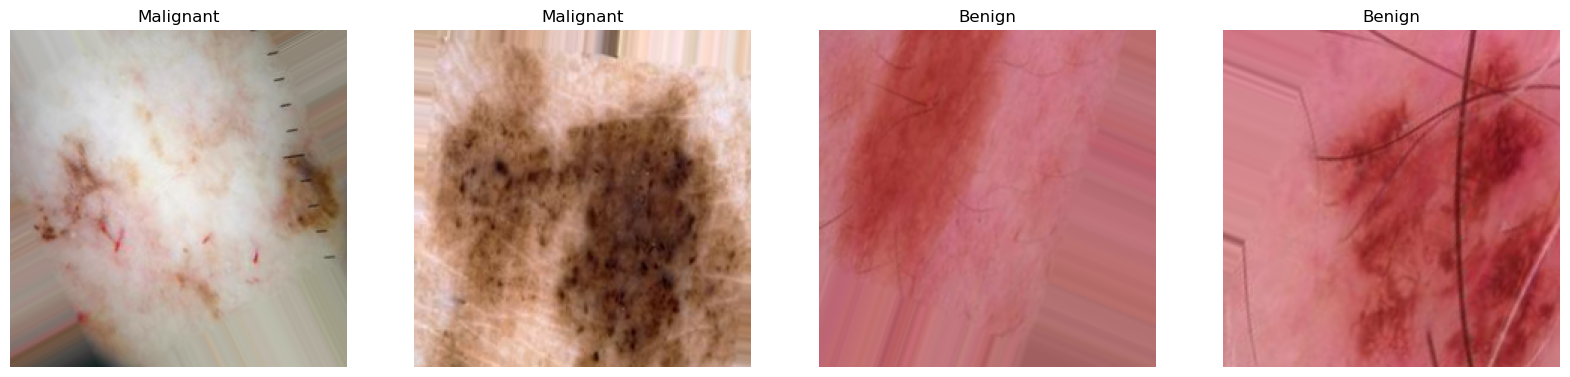

In [142]:
# Fetch a batch of images and labels
images, labels = next(train_generator)

# Define the number of images you want to display
n_images = 4

# Set up the plot
fig, axes = plt.subplots(1, n_images, figsize=(20, 20))

# Display the first 'n_images' images
for i in range(n_images):
    ax = axes[i]
    ax.imshow(images[i])  # Display an image
    label = 'Malignant' if labels[i] > 0.5 else 'Benign'  # Determine the label based on the binary classification
    ax.set_title(label)  # Set the title of the subplot to the corresponding label
    ax.axis('off')  # Turn off axis

plt.show()


# Model

Setup the model

In [117]:
# Define your model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Dropout(0.2),  # Add dropout after pooling layer
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),  # Add dropout after pooling layer
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),  # Add dropout after pooling layer
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.5),  # Add dropout after pooling layer
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),  # Add dropout before the final output layer
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification, so using sigmoid activation
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

## Train the Model

In [127]:
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [128]:
def adjust_batch_size(epoch, initial_batch_size=16, adjustment_strategy=None, max_batch_size=512):
    # Example strategy: double the batch size after every 4 epochs
    if adjustment_strategy == 'double_every_4':
        factor = epoch // 4
        new_batch_size = initial_batch_size * (2 ** factor)
    else:
        return initial_batch_size

    # Ensure the batch size does not exceed the maximum limit
    return min(new_batch_size, max_batch_size)

In [129]:
class LearningRateReducer(keras.callbacks.Callback):
    def __init__(self, factor=0.1, patience=3, min_lr=0):
        super(LearningRateReducer, self).__init__()
        self.factor = factor
        self.patience = patience
        self.min_lr = min_lr

    def on_epoch_end(self, epoch, logs=None):
        old_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        new_lr = max(old_lr * self.factor, self.min_lr)
        self.model.optimizer.learning_rate.assign(new_lr)

In [130]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []


best_val_loss = float('inf')  # Initialize the best validation loss to infinity
patience = 5  # Number of epochs to wait after val loss has stopped improving
patience_counter = 0  # Counter for how many epochs we have waited

epochs = 65
initial_batch_size = 16

learning_rate_reducer = LearningRateReducer(factor=0.95, patience=2, min_lr=0.00001)

for epoch in range(epochs):
    batch_size = adjust_batch_size(epoch, initial_batch_size, 'double_every_4')
    
    # Recreate the train_generator with the new batch size
    train_folder = "images/train"

    # Create a generator for training data
    train_generator = train_datagen.flow_from_directory(
        train_folder,               # Path to the training data folder
        target_size=(224, 224),     # Resize images to 224x224
        batch_size=batch_size,              # Batch size
        class_mode='binary',    # Class mode for binary classification
        shuffle=True
    )
    
    # Perform training for the epoch
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=1,  # We are manually looping over epochs, so fit for 1 epoch at a time
        verbose=1,
        callbacks=[learning_rate_reducer]
    )
    
    # Get the current epoch's validation loss
    current_val_loss = history.history['val_loss'][0]
    
    # Check if the current validation loss is the best we've seen so far
    if current_val_loss < best_val_loss:
        best_val_loss = current_val_loss
        patience_counter = 0
        # Save the model weights
        weights = model.get_weights()
    else:
        patience_counter += 1  # Increment the patience counter
    
    train_losses.append(history.history['loss'][0])
    val_losses.append(history.history['val_loss'][0])
    train_accuracies.append(history.history['accuracy'][0])
    val_accuracies.append(history.history['val_accuracy'][0])
    
    current_lr = model.optimizer.learning_rate.numpy()
    print(f"Epoch {epoch + 1}: Learning Rate = {round(current_lr,5)}")
    
    # Check if early stopping condition is met
    if patience_counter >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}")
        # Restore the best model weights
        # Restore the model's weights
        model.set_weights(weights)
        break  # Exit the training loop

Found 9504 images belonging to 2 classes.
594/594 [==============================] - 199s 335ms/step - loss: 0.6396 - accuracy: 0.6393 - val_loss: 0.6244 - val_accuracy: 0.6337
Epoch 1: Learning Rate = 0.0009500000160187483
Found 9504 images belonging to 2 classes.
594/594 [==============================] - 190s 320ms/step - loss: 0.5825 - accuracy: 0.6886 - val_loss: 0.5706 - val_accuracy: 0.7183
Epoch 2: Learning Rate = 0.0008999999845400453
Found 9504 images belonging to 2 classes.
594/594 [==============================] - 190s 319ms/step - loss: 0.5011 - accuracy: 0.7599 - val_loss: 0.5536 - val_accuracy: 0.7482
Epoch 3: Learning Rate = 0.000859999970998615
Found 9504 images belonging to 2 classes.
594/594 [==============================] - 190s 320ms/step - loss: 0.4373 - accuracy: 0.8101 - val_loss: 0.4673 - val_accuracy: 0.7987
Epoch 4: Learning Rate = 0.0008099999977275729
Found 9504 images belonging to 2 classes.
297/297 [==============================] - 179s 603ms/step - lo

In [100]:
# val_steps = len(val_generator)

# # Train the model using the generator and validate after each epoch
# history = model.fit(
#     train_generator,
#     steps_per_epoch=len(train_generator),
#     epochs=15,
#     validation_data=val_generator,
#     validation_steps=val_steps,
#     callbacks=[early_stopping]
# )

Epoch 1/15
297/297 [==============================] - 180s 604ms/step - loss: 0.5330 - accuracy: 0.7302 - val_loss: 0.6704 - val_accuracy: 0.4779
Epoch 2/15
297/297 [==============================] - 182s 612ms/step - loss: 0.4317 - accuracy: 0.8058 - val_loss: 0.4689 - val_accuracy: 0.8093
Epoch 3/15
297/297 [==============================] - 179s 601ms/step - loss: 0.4124 - accuracy: 0.8220 - val_loss: 0.5798 - val_accuracy: 0.5659
Epoch 4/15
297/297 [==============================] - 171s 575ms/step - loss: 0.4032 - accuracy: 0.8259 - val_loss: 0.5210 - val_accuracy: 0.7777
Epoch 5/15
297/297 [==============================] - 174s 584ms/step - loss: 0.3919 - accuracy: 0.8306 - val_loss: 0.4215 - val_accuracy: 0.8143
Epoch 6/15
297/297 [==============================] - 172s 579ms/step - loss: 0.3776 - accuracy: 0.8328 - val_loss: 0.5090 - val_accuracy: 0.7613
Epoch 7/15
297/297 [==============================] - 173s 580ms/step - loss: 0.3811 - accuracy: 0.8335 - val_loss: 0.5581 -

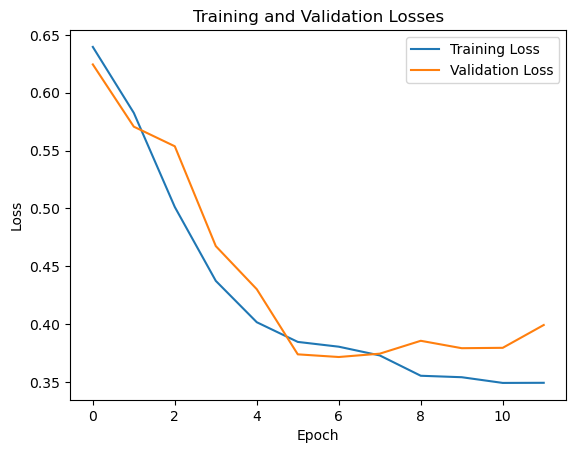

In [132]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

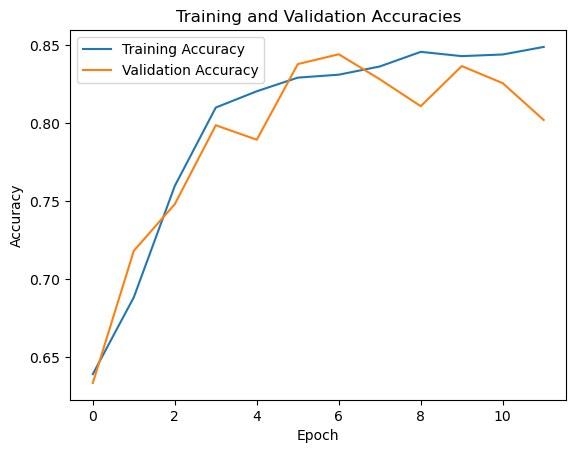

In [133]:
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

# Evaluate on Test Data

In [134]:
test_preds = model.predict(test_generator, steps=len(test_generator))
y_preds = (test_preds > 0.5).astype(int)
y_true = test_generator.classes

63/63 [==============================] - 10s 160ms/step


In [135]:
accuracy = accuracy_score(y_true, y_preds)
print("Accuracy:", accuracy)

Accuracy: 0.8635


In [136]:
cm = confusion_matrix(y_true, y_preds)
cm

array([[875, 125],
       [148, 852]])

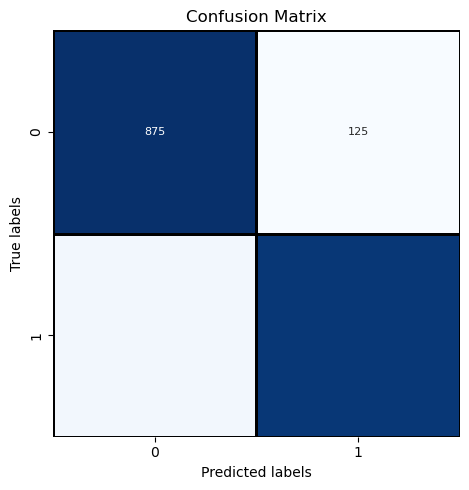

In [137]:
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', annot_kws={'size': 8}, cmap='Blues', cbar=False, square=True, linecolor='black', linewidth=1)

plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()